In [185]:
from sklearn.inspection import permutation_importance

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, true_positive_rate,false_positive_rate

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


import numpy as np

In [186]:
#Datei einlesen
df = pd.read_csv("heart3.csv")
#df = pd.read_csv("/Users/aurelia/Documents/GitHub/Asai-Projekt/heart3.csv")
#df = pd.read_csv(r"C:\Users\Aurelia\OneDrive\Dokumente\GitHub\Asai-Projekt\heart3.csv")
df_orginal = df.copy()

In [187]:
#DataFrame-Beispiel Daten
styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.000000,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.000000,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.000000,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.500000,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.000000,Up,0


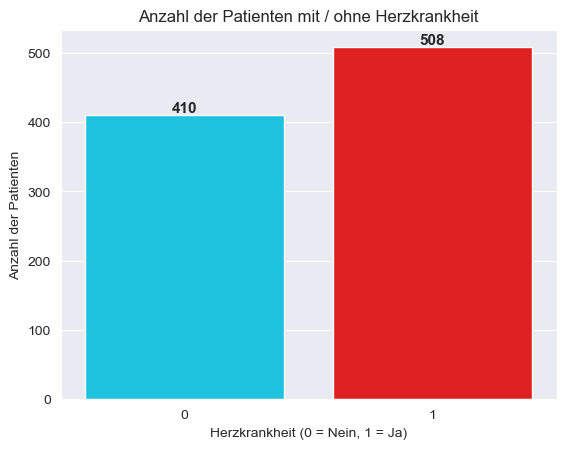

Anzahl der Zeilen (Patienten): 918
Anzahl der Spalten (Features): 12


In [188]:
#Balkendiagramm Anteil Herzerkrankte

# Balkendiagramm
ax = sns.countplot(x='HeartDisease', hue='HeartDisease', data=df, palette=['#00d9ff', '#ff0000'], legend=False)

# Achsentitel
plt.title('Anzahl der Patienten mit / ohne Herzkrankheit')
plt.xlabel('Herzkrankheit (0 = Nein, 1 = Ja)')
plt.ylabel('Anzahl der Patienten')

# Zahlen über Balken schreiben
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom',
                fontsize=11, fontweight='bold')

# Plot anzeigen
plt.show()
print(f"Anzahl der Zeilen (Patienten): {df.shape[0]}")
print(f"Anzahl der Spalten (Features): {df.shape[1]}")

In [189]:
# Daten Vorverarbeitung
# Duplikate checken
# Alle duplizierten Zeilen (inkl. Erstvorkommen)
duplikate_df = df[df.duplicated(keep=False)]

# Anzahl und Prozent Duplikate
anzahl_duplikate = len(duplikate_df)
gesamt = len(df)
prozent_duplikate = (anzahl_duplikate / gesamt) * 100

# Verteilung HeartDisease in den Duplikaten
verteilung_duplikate = duplikate_df['HeartDisease'].value_counts(normalize=True) * 100

# Verteilung HeartDisease im gesamten DataFrame
verteilung_gesamt = df['HeartDisease'].value_counts(normalize=True) * 100

# Ausgabe
print("Gesamtzeilen:", gesamt)
print("Anzahl mehrfach vorkommender Zeilen:", anzahl_duplikate)
print(f"Prozent mehrfach vorkommend: {prozent_duplikate:.2f}%\n")

print("Verteilung von Heartdisease innerhalb der Duplikate:")
if not verteilung_duplikate.empty:
    for wert, proz in verteilung_duplikate.items():
        print(f"  {wert}: {proz:.2f}%")
else:
    print("    - - -")

print("\nGesamtverteilung HeartDisease:")
for wert, proz in verteilung_gesamt.items():
    print(f"  {wert}: {proz:.2f}%")

Gesamtzeilen: 918
Anzahl mehrfach vorkommender Zeilen: 0
Prozent mehrfach vorkommend: 0.00%

Verteilung von Heartdisease innerhalb der Duplikate:
    - - -

Gesamtverteilung HeartDisease:
  1: 55.34%
  0: 44.66%


In [190]:
# Duplikate entfernen
df = df.drop_duplicates()


In [191]:
# Fehlende Werte prüfen
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [192]:
# Typprüfung
# also ob wirklich die im Datensatz angegebenen Datentypen und Beizeichnungen stimmen
def check_values(df, column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte '{column_type}' nicht im Datensatz gefunden.")
        return

    values = df[column_type].dropna().unique()
    invalid = set(values).difference(set(valid_values))
    if invalid:
         print(f" Ungültige Werte in Spalte '{column_type}': {(invalid)} ")
    else:
        print(f"Alle Werte in Spalte '{column_type}' sind gültig ")

valid_values_dict = {
    "Sex": {'M', 'F'},
    "ChestPainType": {'TA', 'ATA', 'NAP', 'ASY'},
    "RestingECG": {'Normal', 'ST', 'LVH'},
    "ExerciseAngina": {'Y', 'N'},
    "ST_Slope": {'Up', 'Flat', 'Down'}
}
def check_if_numeric (df, column_type, valid_values):
    if column_type not in df.columns:
        print(f"Spalte {column_type}' nicht im Datensatz gefunden.")
        return
    else:
        non_numeric = df[column_type].dropna().apply(lambda x: not isinstance(x, (int, float)))
        if non_numeric.any():
            count_invalid = non_numeric.sum()
            print(f"{count_invalid} nicht numerische Werte in Spalte '{column_type}'")
            print(f"Beispiele: {df[column_type][non_numeric].unique()[:5]}")
        else:
            print(f"Alle Werte in Spalte '{column_type}' sind numerisch.")

numeric_columns = [
    'Age',
    'RestingBP',
    'Cholesterol',
    'FastingBS',
    'MaxHR',
    'Oldpeak',
    'HeartDisease'
]
# Anwendung:
for column, valid_set in valid_values_dict.items():
    check_values(df, column, valid_set)

for col in numeric_columns:
    check_if_numeric(df, col, numeric_columns)

Alle Werte in Spalte 'Sex' sind gültig 
Alle Werte in Spalte 'ChestPainType' sind gültig 
Alle Werte in Spalte 'RestingECG' sind gültig 
Alle Werte in Spalte 'ExerciseAngina' sind gültig 
Alle Werte in Spalte 'ST_Slope' sind gültig 
Alle Werte in Spalte 'Age' sind numerisch.
Alle Werte in Spalte 'RestingBP' sind numerisch.
Alle Werte in Spalte 'Cholesterol' sind numerisch.
Alle Werte in Spalte 'FastingBS' sind numerisch.
Alle Werte in Spalte 'MaxHR' sind numerisch.
Alle Werte in Spalte 'Oldpeak' sind numerisch.
Alle Werte in Spalte 'HeartDisease' sind numerisch.


In [193]:
# Unrealistische Werte
limits = {
    'Age': (0, 120),
    'RestingBP': (40, 150),
    'Cholesterol': (1, 800),
    'MaxHR': (60, 202),
    'Oldpeak': (0, 5)
}

print(f"Anzahl an Zeilen (vorher): {len(df)}")

def show_outliers(df, limits_dict):
    for col, (min_val, max_val) in limits_dict.items():
        invalid = df[(df[col] < min_val) | (df[col] > max_val)][col]
        print(f"{col}: {len(invalid)} Werte außerhalb ({min_val}–{max_val})")
        if not invalid.empty:
            print(f"    Beispiele: {invalid.unique()[:5]}")


def remove_outliers(df, limits_dict):
    condition = pd.Series([True] * len(df))
    for col, (min_val, max_val) in limits_dict.items():
        condition &= df[col].between(min_val, max_val)

    return df[condition]

def clip_outliers(df, limits_dict):
    df_clipped = df.copy()
    for col, (min_val, max_val) in limits_dict.items():
        before = df_clipped[col]
        below = before < min_val
        above = before > max_val

        df_clipped[col] = before.clip(lower=min_val, upper=max_val)
    print("\nClipping angewenden:")
    df = df_clipped
    show_outliers(df, limits)
    return df_clipped

show_outliers(df, limits)
clip_outliers(df, limits)
print(f"\nNeue Anzahl an Zeilen (nach Filter): {len(df)}")

Anzahl an Zeilen (vorher): 918
Age: 0 Werte außerhalb (0–120)
RestingBP: 118 Werte außerhalb (40–150)
    Beispiele: [160 170 190 180 155]
Cholesterol: 172 Werte außerhalb (1–800)
    Beispiele: [0]
MaxHR: 0 Werte außerhalb (60–202)
Oldpeak: 15 Werte außerhalb (0–5)
    Beispiele: [-0.9 -2.6 -1.5 -0.1 -1. ]

Clipping angewenden:
Age: 0 Werte außerhalb (0–120)
RestingBP: 0 Werte außerhalb (40–150)
Cholesterol: 0 Werte außerhalb (1–800)
MaxHR: 0 Werte außerhalb (60–202)
Oldpeak: 0 Werte außerhalb (0–5)

Neue Anzahl an Zeilen (nach Filter): 918


Altersverteilung 
count    918.000000
mean      53.510893
std        9.432617
min       28.000000
25%       47.000000
50%       54.000000
75%       60.000000
max       77.000000
Name: Age, dtype: float64


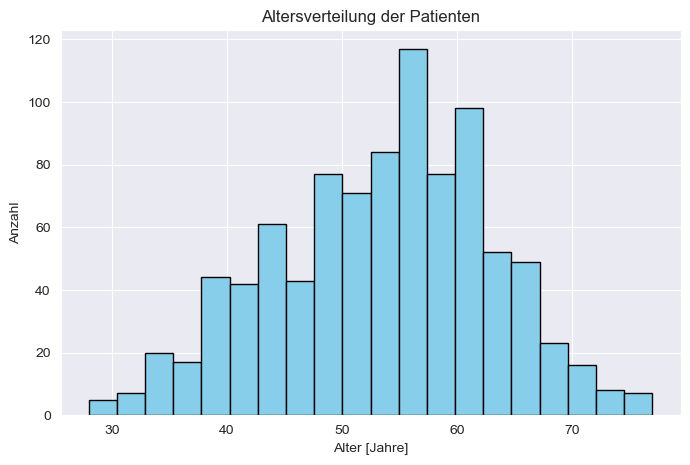

In [194]:
#Bias/Korrelation

print("Altersverteilung ")
print(df['Age'].describe())

plt.figure(figsize=(8,5))
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Altersverteilung der Patienten')
plt.xlabel('Alter [Jahre]')
plt.ylabel('Anzahl')
plt.show()

 Geschlechterverteilung 
M: 725 Patienten (78.98%)
F: 193 Patienten (21.02%)


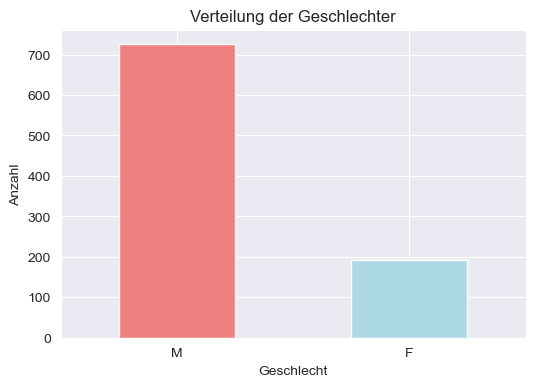

In [195]:
print(" Geschlechterverteilung ")
gender_counts = df['Sex'].value_counts()
gender_percent = df['Sex'].value_counts(normalize=True) * 100

for sex in gender_counts.index:
    print(f"{sex}: {gender_counts[sex]} Patienten ({gender_percent[sex]:.2f}%)")

plt.figure(figsize=(6,4))
gender_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Verteilung der Geschlechter')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.xticks(rotation=0)
plt.show()


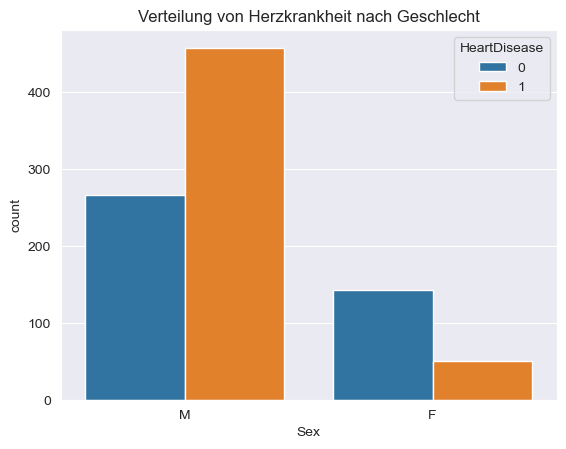

Sex
F    0.259067
M    0.631724
Name: HeartDisease, dtype: float64


In [196]:
# Bias: Zielverteilung nach Geschlecht
sns.countplot(data=df, x='Sex', hue='HeartDisease')
plt.title("Verteilung von Herzkrankheit nach Geschlecht")
plt.show()

# Diagnosewahrscheinlichkeit pro Geschlecht
print(df.groupby("Sex")["HeartDisease"].mean())

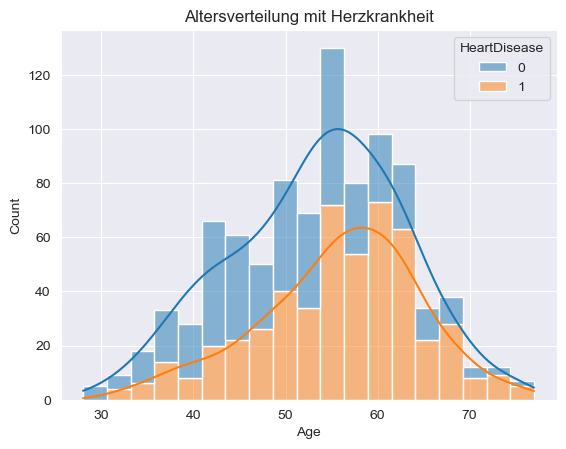

Age_cat
20–30    0.000000
31–40    0.363636
41–50    0.417040
51–60    0.582677
61–80    0.728507
Name: HeartDisease, dtype: float64


In [197]:
#Bias: Altersverteilung mit/ohne Herzkrankheit
sns.histplot(data=df, x='Age', hue='HeartDisease', kde=True, multiple='stack')
plt.title("Altersverteilung mit Herzkrankheit")
plt.show()

# Altersgruppenbildung für Analyse
df['Age_cat'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 80],
                        labels=["20–30", "31–40", "41–50", "51–60", "61–80"])
print(df.groupby("Age_cat", observed=True)["HeartDisease"].mean())


In [198]:
# Anteil Herzkrankheiten bei Fasting Blood Sugar hoch/niedrig
print(df.groupby("FastingBS")["HeartDisease"].mean())

FastingBS
0    0.480114
1    0.794393
Name: HeartDisease, dtype: float64


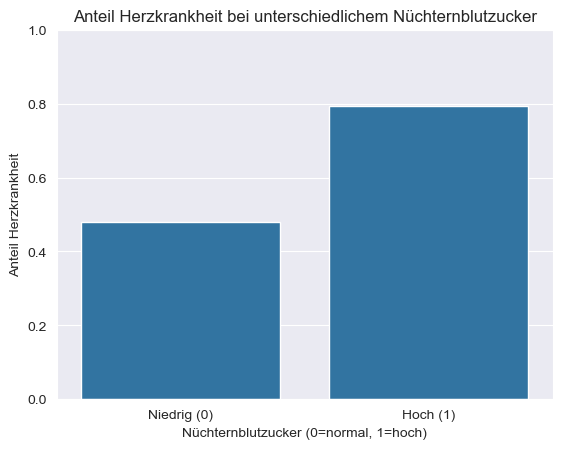

FastingBS
0    0.480114
1    0.794393
Name: HeartDisease, dtype: float64


In [199]:
# Anteil Herzkrankheiten pro Nüchternblutzucker
heart_disease_rate = df.groupby("FastingBS")["HeartDisease"].mean().reset_index()

# Plot mit Seaborn
sns.barplot(data=heart_disease_rate, x="FastingBS", y="HeartDisease")

plt.xticks([0, 1], ['Niedrig (0)', 'Hoch (1)'])
plt.ylabel("Anteil Herzkrankheit")
plt.xlabel("Nüchternblutzucker (0=normal, 1=hoch)")
plt.title("Anteil Herzkrankheit bei unterschiedlichem Nüchternblutzucker")
plt.ylim(0, 1)  # y-Achse von 0 bis 1
plt.show()

print(df.groupby("FastingBS")["HeartDisease"].mean())

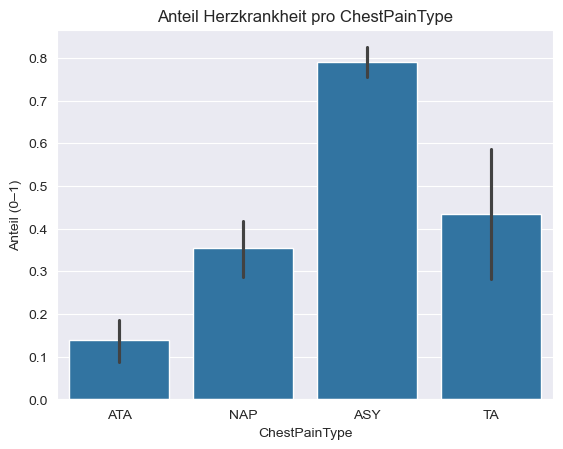

Anteil an Herzkrankheiten (%) pro ChestPainType:

ChestPainType
ASY    79.03
TA     43.48
NAP    35.47
ATA    13.87
Name: HeartDisease, dtype: float64


In [200]:
# Kreuztabelle: Anzahl Herzkrankheiten pro ChestPainType
#pd.crosstab(df['ChestPainType'], df['HeartDisease'], normalize='index') * 100

#  Anteil Herzkrankheit je ChestPainType
sns.barplot(
    data=df,
    x='ChestPainType',
    y='HeartDisease',
    estimator=lambda x: sum(x) / len(x)  # Mittelwert = Anteil Herzkrankheit
)
plt.title("Anteil Herzkrankheit pro ChestPainType")
plt.ylabel("Anteil (0–1)")
plt.show()

# Prozentsatz Herzkrankheit pro ChestPainType
heart_disease_by_cp = df.groupby("ChestPainType")["HeartDisease"].mean().sort_values(ascending=False) * 100

print("Anteil an Herzkrankheiten (%) pro ChestPainType:\n")
print(heart_disease_by_cp.round(2))

In [201]:
#!!! löschen


# Feature-Liste
features = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol',
            'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

# Kategorische Features umwandeln
df_encoded = pd.get_dummies(df[features], drop_first=True)
X = df_encoded
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Gesamtergebnis:")
print(classification_report(y_test, y_pred))


Gesamtergebnis:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       103
           1       0.90      0.91      0.90       127

    accuracy                           0.89       230
   macro avg       0.89      0.89      0.89       230
weighted avg       0.89      0.89      0.89       230



In [202]:
# Feature Engineering
"""
# Resting BP
def restingBP_categorization(bp):
    if bp < 120:
        return 100
    elif 120<= bp <= 129:
        return 125
    elif 130<= bp <= 139:
        return 135
    elif 140<= bp <= 179:
        return 160
    else: return 190

df['RestingBP'] = df['RestingBP'].apply(restingBP_categorization)

def cholesterol_category_by_age(row):
    age = row['Age']
    sex = row['Sex']
    chol = row['Cholesterol']

    # Wertebereiche laut Tabelle (vereinfacht)
    if sex == 'M':  # Männer
        if age < 40:
            min_val, max_val = 150, 220
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 240
        else:
            min_val, max_val = 175, 240
    else:  # Frauen
        if age < 40:
            min_val, max_val = 150, 240
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 260
        else:
            min_val, max_val = 195, 270

    if chol < min_val:
        return 0
    elif chol > max_val:
        return 1
    else:
        return 0.5

df['Cholesterol_cat_age'] = df.apply(cholesterol_category_by_age, axis=1)

# Max HR
def maxhr_age_category(row):
    maxhr = row['MaxHR']
    age = row['Age']
    expected_maxhr = 220 - age

    if maxhr < 0.7 * expected_maxhr:
        return 1
    elif 0.7 * expected_maxhr <= maxhr <= expected_maxhr:
        return 2
    elif expected_maxhr < maxhr <= 1.1 * expected_maxhr:
        return 3
    else:
        return 4

df['MaxHR'] = df.apply(maxhr_age_category, axis=1)


def age_category(age_group):
    if age_group == '20–30':
        return 25
    elif age_group == '31–40':
        return 36
    elif age_group == '41–50':
        return 46
    elif age_group == '51–60':
        return 56
    elif age_group == '61–80':
        return 70
    else:
        return 0

df['Age_cat'] = df['Age_cat'].apply(age_category)

#One Hot Encoding bei Nominalen Kategorien
# One-Hot-Encoding für nominale Kategorien
df = pd.get_dummies(df, columns=["ChestPainType", "RestingECG", "ST_Slope"], drop_first=True, dtype=int)


# Mapping für Sex (Männlich = 1, Weiblich = 0)
df["Sex"] = df["Sex"].map({'M': 1, 'F': 0})

# Mapping für ExerciseAngina (Ja = 1, Nein = 0)
df["ExerciseAngina"] = df["ExerciseAngina"].map({'Y': 1, 'N': 0})

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df
"""

'\n# Resting BP\ndef restingBP_categorization(bp):\n    if bp < 120:\n        return 100\n    elif 120<= bp <= 129:\n        return 125\n    elif 130<= bp <= 139:\n        return 135\n    elif 140<= bp <= 179:\n        return 160\n    else: return 190\n\ndf[\'RestingBP\'] = df[\'RestingBP\'].apply(restingBP_categorization)\n\ndef cholesterol_category_by_age(row):\n    age = row[\'Age\']\n    sex = row[\'Sex\']\n    chol = row[\'Cholesterol\']\n\n    # Wertebereiche laut Tabelle (vereinfacht)\n    if sex == \'M\':  # Männer\n        if age < 40:\n            min_val, max_val = 150, 220\n        elif age < 50:\n            min_val, max_val = 160, 240\n        elif age < 60:\n            min_val, max_val = 170, 240\n        else:\n            min_val, max_val = 175, 240\n    else:  # Frauen\n        if age < 40:\n            min_val, max_val = 150, 240\n        elif age < 50:\n            min_val, max_val = 160, 240\n        elif age < 60:\n            min_val, max_val = 170, 260\n       

In [203]:
# Feature Engineering aber kategorisiert und ohne

# Resting BP
def restingBP_categorization(bp):
    if bp < 120:
        return 100
    elif 120 <= bp <= 129:
        return 125
    elif 130 <= bp <= 139:
        return 135
    elif 140 <= bp <= 179:
        return 160
    else:
        return 190


df['RestingBP_cat'] = df['RestingBP'].apply(restingBP_categorization)


def cholesterol_category_by_age(row):
    age = row['Age']
    sex = row['Sex']
    chol = row['Cholesterol']

    # Wertebereiche laut Tabelle (vereinfacht)
    if sex == 'M':  # Männer
        if age < 40:
            min_val, max_val = 150, 220
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 240
        else:
            min_val, max_val = 175, 240
    else:  # Frauen
        if age < 40:
            min_val, max_val = 150, 240
        elif age < 50:
            min_val, max_val = 160, 240
        elif age < 60:
            min_val, max_val = 170, 260
        else:
            min_val, max_val = 195, 270

    if chol < min_val:
        return 0
    elif chol > max_val:
        return 1
    else:
        return 0.5


df['Cholesterol_cat_age'] = df.apply(cholesterol_category_by_age, axis=1)


# Max HR
def maxhr_age_category(row):
    maxhr = row['MaxHR']
    age = row['Age']
    expected_maxhr = 220 - age

    if maxhr < 0.7 * expected_maxhr:
        return 1
    elif 0.7 * expected_maxhr <= maxhr <= expected_maxhr:
        return 2
    elif expected_maxhr < maxhr <= 1.1 * expected_maxhr:
        return 3
    else:
        return 4


df['MaxHR_cat'] = df.apply(maxhr_age_category, axis=1)


def age_category(age_group):
    if age_group == '20–30':
        return 25
    elif age_group == '31–40':
        return 36
    elif age_group == '41–50':
        return 46
    elif age_group == '51–60':
        return 56
    elif age_group == '61–80':
        return 70
    else:
        return 0


df['Age_cat'] = df['Age_cat'].apply(age_category)

#One Hot Encoding bei Nominalen Kategorien
# One-Hot-Encoding für nominale Kategorien
df = pd.get_dummies(df, columns=["ChestPainType", "RestingECG", "ST_Slope"], drop_first=True, dtype=int)

# Mapping für Sex (Männlich = 1, Weiblich = 0)
df["Sex"] = df["Sex"].map({'M': 1, 'F': 0})

# Mapping für ExerciseAngina (Ja = 1, Nein = 0)
df["ExerciseAngina"] = df["ExerciseAngina"].map({'Y': 1, 'N': 0})

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Age_cat,RestingBP_cat,Cholesterol_cat_age,MaxHR_cat,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.000000,0,36,160,1.000000,2,1,0,0,1,0,0,1
1,49,0,160,180,0,156,0,1.000000,1,46,160,0.500000,2,0,1,0,1,0,1,0
2,37,1,130,283,0,98,0,0.000000,0,36,135,1.000000,1,1,0,0,0,1,0,1
3,48,0,138,214,0,108,1,1.500000,1,46,135,0.500000,1,0,0,0,1,0,1,0
4,54,1,150,195,0,122,0,0.000000,0,56,160,0.500000,2,0,1,0,1,0,0,1
5,39,1,120,339,0,170,0,0.000000,0,36,125,1.000000,2,0,1,0,1,0,0,1
6,45,0,130,237,0,170,0,0.000000,0,46,135,0.500000,2,1,0,0,1,0,0,1
7,54,1,110,208,0,142,0,0.000000,0,56,100,0.500000,2,1,0,0,1,0,0,1
8,37,1,140,207,0,130,1,1.500000,1,36,160,0.500000,2,0,0,0,1,0,1,0
9,48,0,120,284,0,120,0,0.000000,0,46,125,1.000000,1,1,0,0,1,0,0,1


In [204]:
#Skalieren
scaler = MinMaxScaler()
#scale_cols = ["RestingBP", "Cholesterol", "MaxHR", "ExerciseAngina", "Oldpeak", "Age_cat", "ChestPainType_ATA", "ChestPainType_NAP", "ChestPainType_TA", "RestingECG_Normal", "RestingECG_ST", "ST_Slope_Flat", "ST_Slope_Up"]
scale_cols = ["RestingBP", "Cholesterol", "MaxHR", "Oldpeak", "Age_cat", "RestingBP_cat", "Cholesterol_cat_age", "MaxHR_cat",]
df[scale_cols] = scaler.fit_transform(df[scale_cols])

styled_df = df.head(10).style.set_table_styles([
    {'selector': 'thead th', 'props': [('background-color', '#1f77b4'), ('color', 'white'), ('font-weight', 'bold')]},
    {'selector': 'tbody td', 'props': [('border', '1px solid #ddd'), ('text-align', 'center')]}
]).set_properties(**{'text-align': 'center'})

styled_df

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,Age_cat,RestingBP_cat,Cholesterol_cat_age,MaxHR_cat,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,0.700000,0.479270,0,0.788732,0,0.295455,0,0.244444,0.666667,1.000000,0.333333,1,0,0,1,0,0,1
1,49,0,0.800000,0.298507,0,0.676056,0,0.409091,1,0.466667,0.666667,0.500000,0.333333,0,1,0,1,0,1,0
2,37,1,0.650000,0.469320,0,0.267606,0,0.295455,0,0.244444,0.388889,1.000000,0.000000,1,0,0,0,1,0,1
3,48,0,0.690000,0.354892,0,0.338028,1,0.465909,1,0.466667,0.388889,0.500000,0.000000,0,0,0,1,0,1,0
4,54,1,0.750000,0.323383,0,0.436620,0,0.295455,0,0.688889,0.666667,0.500000,0.333333,0,1,0,1,0,0,1
5,39,1,0.600000,0.562189,0,0.774648,0,0.295455,0,0.244444,0.277778,1.000000,0.333333,0,1,0,1,0,0,1
6,45,0,0.650000,0.393035,0,0.774648,0,0.295455,0,0.466667,0.388889,0.500000,0.333333,1,0,0,1,0,0,1
7,54,1,0.550000,0.344942,0,0.577465,0,0.295455,0,0.688889,0.000000,0.500000,0.333333,1,0,0,1,0,0,1
8,37,1,0.700000,0.343284,0,0.492958,1,0.465909,1,0.244444,0.666667,0.500000,0.333333,0,0,0,1,0,1,0
9,48,0,0.600000,0.470978,0,0.422535,0,0.295455,0,0.466667,0.277778,1.000000,0.000000,1,0,0,1,0,0,1


In [205]:
# Train Test Split für RF, LR, Stacking

# 1. Daten vorbereiten: Heartdisease spalte und alte age Spalte entfernen
X = df.drop(columns=['HeartDisease', 'Age', 'Cholesterol'])
y = df['HeartDisease']

# 2. Trainings-/Testdaten Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: False
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Bester CV-Score (grid_search.best_score_): 0.8677


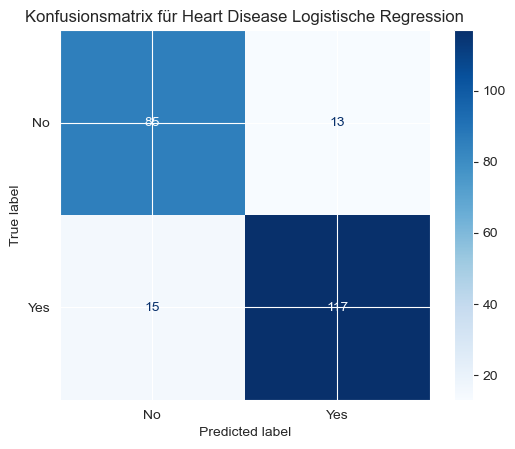

Genauigkeit: 0.8782608695652174

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.846154   0.666667  0.800000  0.727273        0.307692
1    0.884817   0.923729  0.893443  0.908333        0.617801
Demographic Parity Difference: 0.310


In [206]:
#Random Forest mit Gridsearch

# 3. Parametergrid für rf
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

# 5. Beste Parameter und beste Score ausgeben
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")
# 6. Modell evaluieren
best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

#7. Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#8. Fairness-Analyse nach Geschlecht
# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.8691


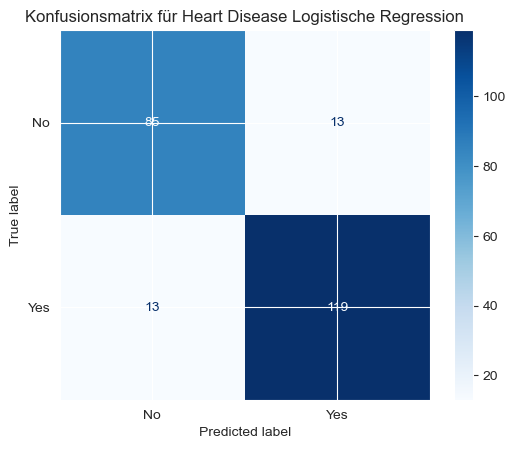

Genauigkeit: 0.8869565217391304

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.846154   0.666667  0.800000  0.727273        0.307692
1    0.895288   0.925000  0.909836  0.917355        0.628272
Demographic Parity Difference: 0.321


In [207]:
#Random Forest mit Gridsearch BALANCED


# 3. Parametergrid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 4. Random Forest mit GridSearchCV + balanced
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

# 5. Beste Parameter und beste Score ausgeben
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")
# 6. Modell evaluieren
best_model = grid_search.best_estimator_
y_pred_rand = best_model.predict(X_test)

#7. Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Random Forest')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#8. Fairness-Analyse nach Geschlecht
# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


In [208]:
# Frauenanteil oversampeln

# 3. Oversampling von Frauen im Trainingsteil
train_df = X_train.copy()
train_df["HeartDisease"] = y_train

# Get Frauen (Sex == 0) und Männer
women = train_df[train_df["Sex"] == 0]
men = train_df[train_df["Sex"] == 1]

# Frauen duplizieren, bis gleiche Anzahl wie Männer
women_oversampled = women.sample(n=len(men), replace=True, random_state=42)

# Kombinieren
train_balanced = pd.concat([men, women_oversampled])
X_train_balanced = train_balanced.drop(columns="HeartDisease")
y_train_balanced = train_balanced["HeartDisease"]

Neue Verteilung im Training:
Sex
1    534
0    534
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.8971


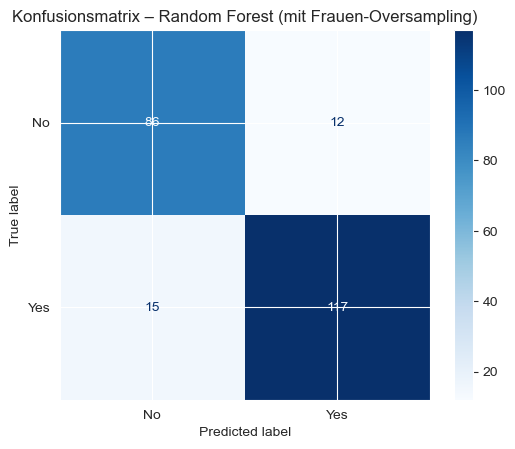

Genauigkeit: 0.8826086956521739

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.871795   0.777778  0.700000  0.736842        0.230769
1    0.884817   0.916667  0.901639  0.909091        0.628272
Demographic Parity Difference: 0.398


In [209]:
#Random Forest MIT Oversamling der Frauen

print(f"Neue Verteilung im Training:\n{X_train_balanced['Sex'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_balanced, y_train_balanced)

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

# 7. Vorhersage & Evaluation
y_pred_rand = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


Neue Verteilung im Training:
Sex
1    534
0    534
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.8999


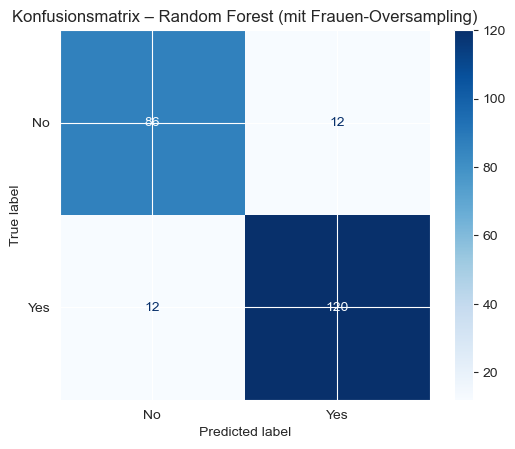

Genauigkeit: 0.8956521739130435

 Predictive Parity (Female): 0.778
 Predictive Parity (Male):   0.919
 Predictive Parity Difference: 0.141

Fairness-Analyse nach 'Sex':
     accuracy  precision   recall  f1_score  selection_rate  \
Sex                                                           
0    0.871795   0.777778  0.70000  0.736842        0.230769   
1    0.900524   0.918699  0.92623  0.922449        0.643979   

     false_positive_rate  true_positive_rate  
Sex                                           
0               0.068966             0.70000  
1               0.144928             0.92623  
Demographic Parity Difference: 0.413


In [210]:

#Random Forest MIT Oversamling der Frauen + balanced

print(f"Neue Verteilung im Training:\n{X_train_balanced['Sex'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_balanced, y_train_balanced)
best_forest_model = grid_search.best_estimator_

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

# 7. Vorhersage & Evaluation
y_pred_rand = best_forest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#Konfusionsmatrix nach mann und frau
# True-Labels und Vorhersagen für jede Gruppe extrahieren
y_true_female = y_test[sensitive_feature == 0]
y_pred_female = y_pred_rand[sensitive_feature == 0]

y_true_male = y_test[sensitive_feature == 1]
y_pred_male = y_pred_rand[sensitive_feature == 1]

# Precision (predictive parity) für beide Gruppen
precision_female = precision_score(y_true_female, y_pred_female)
precision_male = precision_score(y_true_male, y_pred_male)

# Predictive Parity Difference berechnen
pp_diff = abs(precision_female - precision_male)

print(f"\n Predictive Parity (Female): {precision_female:.3f}")
print(f" Predictive Parity (Male):   {precision_male:.3f}")
print(f" Predictive Parity Difference: {pp_diff:.3f}")

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

ST_Slope_Up: 0.0735 ± 0.0116
Cholesterol_cat_age: 0.0404 ± 0.0044
Oldpeak: 0.0383 ± 0.0093
Sex: 0.0357 ± 0.0103
ST_Slope_Flat: 0.0339 ± 0.0091
FastingBS: 0.0257 ± 0.0053
RestingBP: 0.0217 ± 0.0061
MaxHR: 0.0187 ± 0.0055
ExerciseAngina: 0.0174 ± 0.0080
ChestPainType_ATA: 0.0113 ± 0.0078


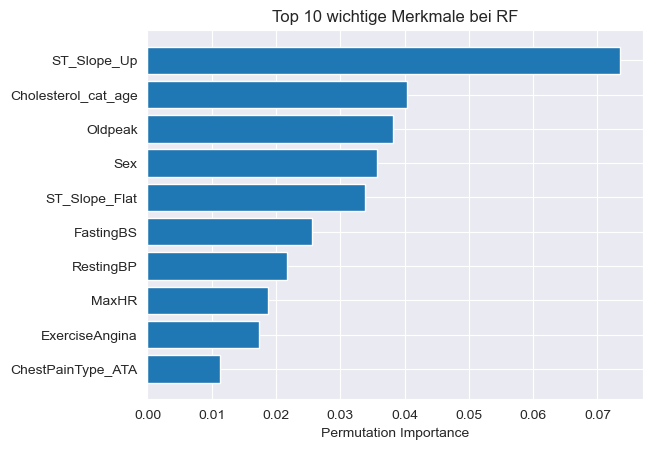

In [211]:
#Top 10 Wichtigste Merkmale bei RF


result = permutation_importance(best_forest_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

#Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei RF")
plt.show()

In [219]:
from imblearn.over_sampling import SMOTE

# SMOTE anwenden nur auf Trainingsdaten
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_balanced, y_train_balanced)

# 4. Ausgabe zur Kontrolle
print("Vor SMOTE:", y_train.value_counts())
print("Nach SMOTE:", y_train_resampled.value_counts())

Vor SMOTE: HeartDisease
1    376
0    312
Name: count, dtype: int64
Nach SMOTE: HeartDisease
1    606
0    606
Name: count, dtype: int64


Neue Verteilung im Training:
Sex
1    534
0    534
Name: count, dtype: int64
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Beste Parameterkombination (grid_search.best_params_):
  bootstrap: True
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 100

Bester CV-Score (grid_search.best_score_): 0.9201


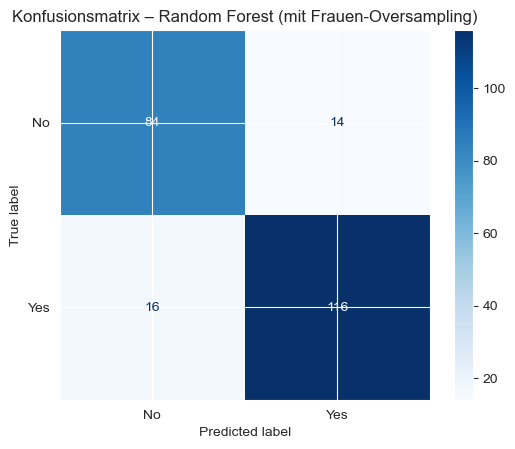

Genauigkeit: 0.8695652173913043

 Predictive Parity (Female): 0.600
 Predictive Parity (Male):   0.917
 Predictive Parity Difference: 0.317

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate  \
Sex                                                            
0    0.794872   0.600000  0.600000  0.600000        0.256410   
1    0.884817   0.916667  0.901639  0.909091        0.628272   

     false_positive_rate  true_positive_rate  
Sex                                           
0               0.137931            0.600000  
1               0.144928            0.901639  
Demographic Parity Difference: 0.372


In [220]:

#Random Forest MIT Oversamling der Frauen + balanced

print(f"Neue Verteilung im Training:\n{X_train_balanced['Sex'].value_counts()}")

# 4. Parametergrid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

# 5. GridSearchCV
rfc = RandomForestClassifier(random_state=42, class_weight='balanced')

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_resampled, y_train_resampled)
best_forest_model = grid_search.best_estimator_

# 6. Bestes Modell
print("Beste Parameterkombination (grid_search.best_params_):")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBester CV-Score (grid_search.best_score_): {grid_search.best_score_:.4f}")

# 7. Vorhersage & Evaluation
y_pred_rand = best_forest_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rand)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix – Random Forest (mit Frauen-Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_rand)
print("Genauigkeit:", accuracy)

#Konfusionsmatrix nach mann und frau
# True-Labels und Vorhersagen für jede Gruppe extrahieren
y_true_female = y_test[sensitive_feature == 0]
y_pred_female = y_pred_rand[sensitive_feature == 0]

y_true_male = y_test[sensitive_feature == 1]
y_pred_male = y_pred_rand[sensitive_feature == 1]

# Precision (predictive parity) für beide Gruppen
precision_female = precision_score(y_true_female, y_pred_female)
precision_male = precision_score(y_true_male, y_pred_male)

# Predictive Parity Difference berechnen
pp_diff = abs(precision_female - precision_male)

print(f"\n Predictive Parity (Female): {precision_female:.3f}")
print(f" Predictive Parity (Male):   {precision_male:.3f}")
print(f" Predictive Parity Difference: {pp_diff:.3f}")

# 8. Fairness-Analyse
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate,
    "false_positive_rate": false_positive_rate,
    "true_positive_rate": true_positive_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_rand, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_rand, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

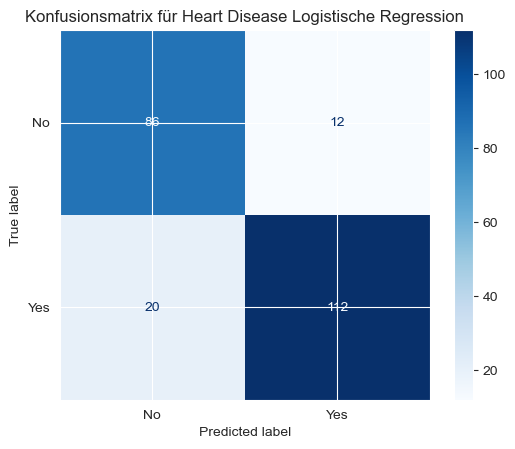

Genauigkeit: 0.8608695652173913
Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.769231   0.555556  0.500000  0.526316        0.230769
1    0.879581   0.930435  0.877049  0.902954        0.602094
Demographic Parity Difference: 0.371


In [212]:
#logisticRegeression balanced


modelLogistic = LogisticRegression(max_iter=1000,class_weight='balanced')
modelLogistic.fit(X_train, y_train)

y_pred = modelLogistic.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print("Genauigkeit:", accuracy)

#Fariness:

# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)

print("Fairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


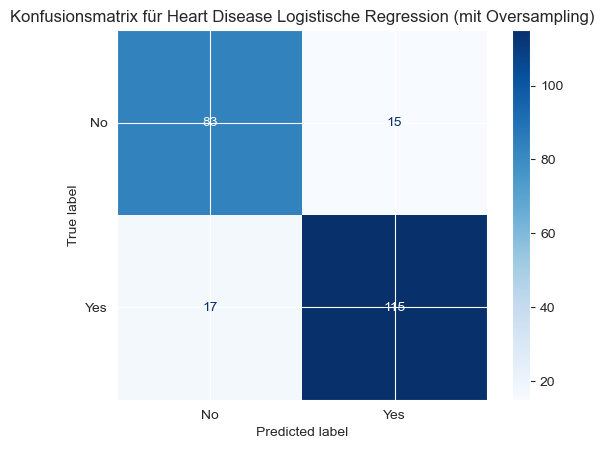

Genauigkeit: 0.8608695652173913

Fairness-Analyse nach 'Sex':
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.769231   0.545455  0.600000  0.571429        0.282051
1    0.879581   0.915966  0.893443  0.904564        0.623037
Demographic Parity Difference: 0.341


In [213]:
#lr mit oversampling der Frauen +balanded

# 4. Modell trainieren
best_lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
best_lr_model.fit(X_train_balanced, y_train_balanced)

# 5. Vorhersage und Evaluation
y_pred_log = best_lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease Logistische Regression (mit Oversampling)')
plt.show()

accuracy = accuracy_score(y_test, y_pred_log)
print("Genauigkeit:", accuracy)

#Fairness
# Sensitives Merkmal extrahieren (Sex)
sensitive_feature = df.loc[X_test.index, "Sex"]  # 0 = Female, 1 = Male

# MetricFrame mit Gruppenvergleich
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}

frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_log, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex':")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_log, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")


ChestPainType_NAP: 0.0317 ± 0.0138
ChestPainType_ATA: 0.0283 ± 0.0152
FastingBS: 0.0226 ± 0.0082
ExerciseAngina: 0.0209 ± 0.0084
Sex: 0.0157 ± 0.0096
ST_Slope_Up: 0.0117 ± 0.0126
ST_Slope_Flat: 0.0100 ± 0.0144
Oldpeak: 0.0078 ± 0.0051
MaxHR: 0.0074 ± 0.0048
Age_cat: 0.0035 ± 0.0051


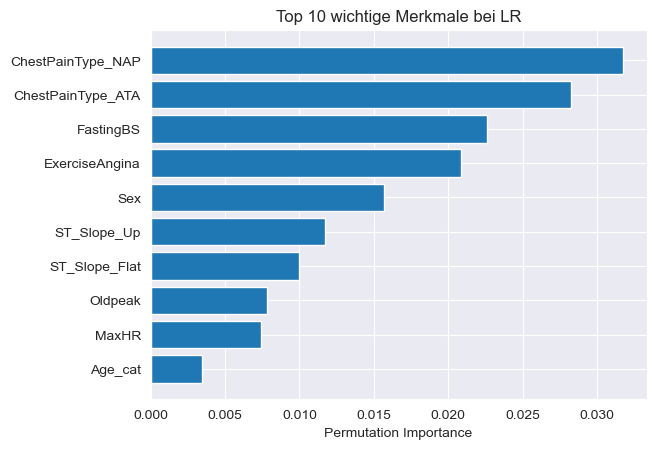

In [214]:
#Top 10 wichtigste Merkmale bei LR
result = permutation_importance(best_lr_model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Sortieren der Features nach Wichtigkeit
sorted_idx = result.importances_mean.argsort()[::-1]
for i in sorted_idx[:10]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# Plot

plt.barh(X_test.columns[sorted_idx[:10]][::-1], result.importances_mean[sorted_idx[:10]][::-1])
plt.xlabel("Permutation Importance")
plt.title("Top 10 wichtige Merkmale bei LR")
plt.show()

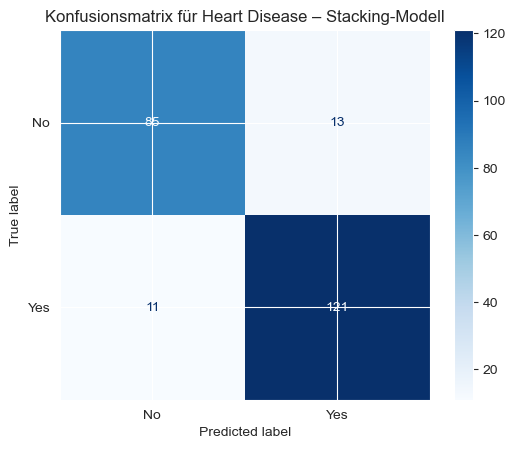

Genauigkeit (Stacking): 0.8956521739130435

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision    recall  f1_score  selection_rate
Sex                                                         
0    0.846154   0.700000  0.700000  0.700000        0.256410
1    0.905759   0.919355  0.934426  0.926829        0.649215
Demographic Parity Difference: 0.393


In [215]:
#Stacking lr, rf als base model und lr als meta model

# Basismodelle (schon trainiert mit SMOTE)
estimators = [
    ('rf', best_forest_model),
    ('lr', best_lr_model),
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)
# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train_balanced, y_train_balanced)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")

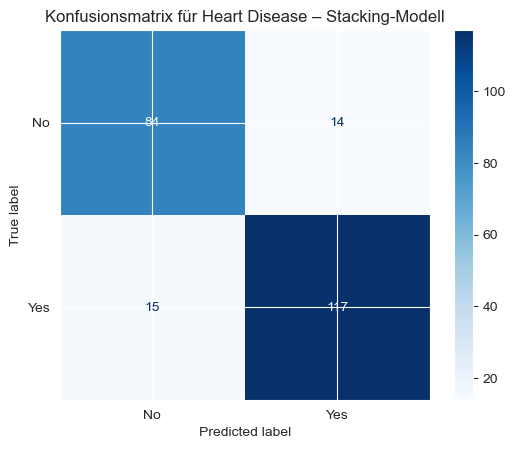

Genauigkeit (Stacking): 0.8739130434782608

Fairness-Analyse nach 'Sex' (Stacking):
     accuracy  precision   recall  f1_score  selection_rate
Sex                                                        
0    0.769231   0.571429  0.40000  0.470588        0.179487
1    0.895288   0.911290  0.92623  0.918699        0.649215
Demographic Parity Difference: 0.470


In [216]:
#Stacking lr, rf und xg boost als base model und lr als meta model

# Basismodelle (lr und rf schon trainiert mit SMOTE)
xgb_model = XGBClassifier(
    eval_metric='logloss',  # wichtig für Klassifikation
    random_state=42
)

estimators = [
    ('rf', best_forest_model),
    ('lr', best_lr_model),
    ('xgb', xgb_model)
]

# Meta-Modell: Logistische Regression
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stacking-Classifier
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    passthrough=False,  # wenn True werden auch Original-Features aus dem Meta-Modell übergeben
    n_jobs=-1
)
# Stacking-Modell (smote Trainingsdaten)
stacked_model.fit(X_train_balanced, y_train_balanced)

#  Vorhersage auf Testdaten
y_pred_stack = stacked_model.predict(X_test)

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_stack)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap='Blues')
plt.title('Konfusionsmatrix für Heart Disease – Stacking-Modell')
plt.show()

accuracy = accuracy_score(y_test, y_pred_stack)
print("Genauigkeit (Stacking):", accuracy)

# Fairness-Analyse
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1_score": f1_score,
    "selection_rate": selection_rate
}
# nach Geschlecht
frame = MetricFrame(metrics=metrics, y_true=y_test, y_pred=y_pred_stack, sensitive_features=sensitive_feature)

print("\nFairness-Analyse nach 'Sex' (Stacking):")
print(frame.by_group)

dp_diff = demographic_parity_difference(y_test, y_pred_stack, sensitive_features=sensitive_feature)
print(f"Demographic Parity Difference: {dp_diff:.3f}")